# Super Resolution implemetation of Deep Image Prior using Keras

Connecting to Gdrive

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# File locations
dir = '/content/drive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Importing packages

In [2]:
import tensorflow as tf

import numpy as np

from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Lambda

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ZeroPadding2D

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

K.set_image_data_format('channels_last')
K.image_data_format()

tf.enable_eager_execution()

Loading image

In [0]:
SCALING_FACTOR = 2
encoding_size = 128
perturbation_max = 40


base_dir = '/content/drive/My Drive/Colab Notebooks/'
path_to_image = base_dir + '/zebra.bmp'
img_orig = Image.open(path_to_image)
img_orig_np = np.array(img_orig).astype(np.float32) / 255

In [4]:
img_orig_np.shape

(391, 586, 3)

In [0]:
img_bicubic = img_orig.resize((int(img_orig.size[0] * SCALING_FACTOR), int(img_orig.size[1] * SCALING_FACTOR)), Image.BICUBIC)
img_bicubic
img_bicubic_np = np.array(img_bicubic).astype(np.float32) / 255

In [0]:
h, w, ch = img_bicubic_np.shape
if h % 64 != 0:
    crop_h = h // 64 * 64
if w % 64 != 0:
    crop_w = w // 64 * 64

img_bicubic_crop = img_bicubic_np[0:crop_h, 0:crop_w, :]

In [7]:
img_bicubic_crop.shape

(768, 1152, 3)

Define model

In [0]:
input_depth = 32
input_dims = (1, crop_h, crop_w, input_depth)

net_input = K.random_uniform(input_dims) #add var

In [9]:
input_dims

(1, 768, 1152, 32)

In [0]:
# base_model = inception_v3.InceptionV3(weights=None, include_top=False, input_shape=input_dims[1:], pooling='avg')
# x = base_model.get_layer('mixed10').output
# x = ZeroPadding2D((1,1))(x)
# x = Convolution2D(256, 3, padding = 'same', activation = 'relu')(x)
# x = BatchNormalization()(x)
# x = UpSampling2D()(x)
# x = Convolution2D(128, 3, padding = 'same', activation = 'relu')(x)
# x = BatchNormalization()(x)
# x = UpSampling2D()(x)
# x = Convolution2D(64, 3, padding = 'same', activation = 'relu')(x)
# x = BatchNormalization()(x)
# x = UpSampling2D()(x)
# x = Convolution2D(32, 3, padding = 'same', activation = 'relu')(x)
# x = BatchNormalization()(x)
# x = UpSampling2D()(x)
# x = Convolution2D(16, 3, padding = 'same', activation = 'relu')(x)
# x = BatchNormalization()(x)
# x = UpSampling2D()(x)
# x = Convolution2D(3, 3, padding = 'same', activation = 'relu')(x)
# model = Model(inputs=base_model.input, outputs=x)

In [0]:
def UpSampling2DBilinear(size):
    return Lambda(lambda x: tf.image.resize_bilinear(x, size, align_corners=True))

model = Sequential([
    Convolution2D(32, 3, padding = 'same', input_shape = input_dims[1:], activation = 'relu'),
    Convolution2D(32, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Convolution2D(128, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Convolution2D(256, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Convolution2D(256, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Convolution2D(512, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    AveragePooling2D(),
    Convolution2D(512, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(256, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(128, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(64, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),    
    Convolution2D(32, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(16, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(16, 3, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    Convolution2D(3, 3, padding = 'same', activation = 'tanh')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 768, 1152, 32)     9248      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 768, 1152, 32)     9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 768, 1152, 32)     128       
_________________________________________________________________
average_pooling2d (AveragePo (None, 384, 576, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 384, 576, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 384, 576, 64)      256       
_________________________________________________________________
average_pooling2d_1 (Average (None, 192, 288, 64)      0

In [0]:
model.compile(tf.train.AdamOptimizer(), loss = 'mse')

In [0]:
n_epochs = 100 #ORIGINAL IS 100
img_batch = np.expand_dims(img_bicubic_crop,0)

fit_params = {
    'x': net_input,
    'y': img_batch,
    'epochs': n_epochs,
    'batch_size': 1,
    'verbose': 0,
    'steps_per_epoch': 1
}

In [15]:
img_batch.shape

(1, 768, 1152, 3)

Run model

In [0]:
#TODO add variance to net_input and change randomisation method
#2D bilinear upscaling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:100


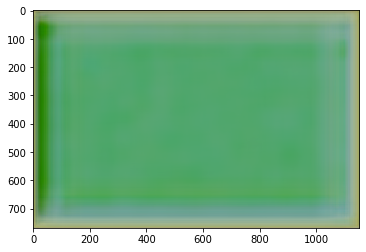

Epoch:200


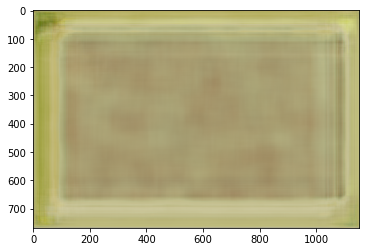

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:300


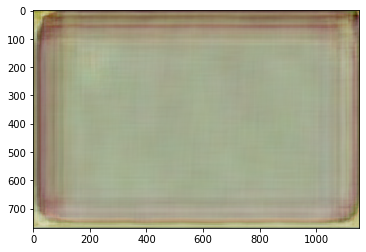

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:400


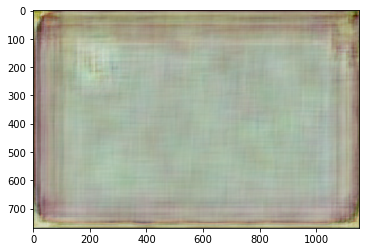

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:500


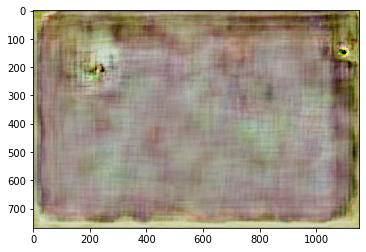

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:600


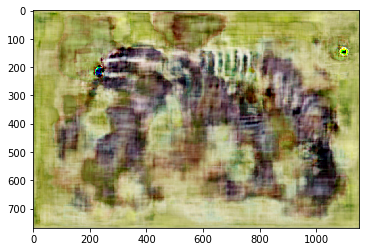

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:700


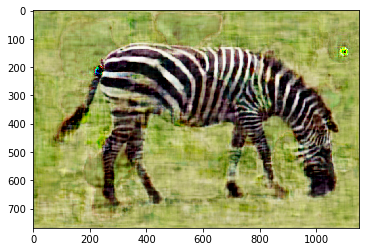

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:800


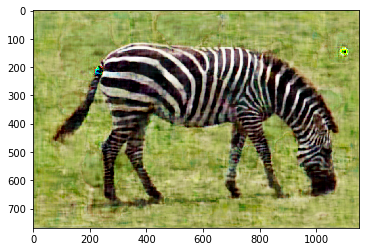

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:900


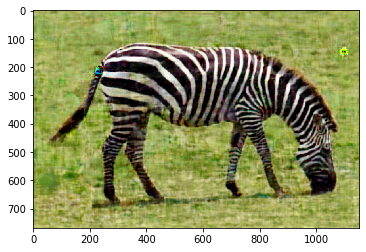

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1000


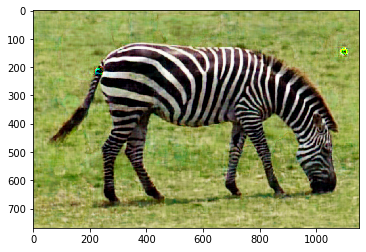

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1100


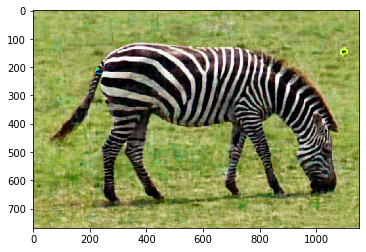

In [0]:
for i in range(50): #Original is 50
    model.fit(**fit_params)
    img_pred = model.predict(net_input, steps=1)
    print('Epoch:' + str((i+1) * n_epochs))
    plt.imshow(img_pred[0])
    plt.show()

In [18]:
import cv2

out_name = 'out/keras_zebra.jpg'
# Save the image to disk
cv2.imwrite(base_dir + out_name, cv2.cvtColor(255 * img_pred[0], cv2.COLOR_RGB2BGR))
#cv2.imwrite(base_dir + out_name, img_pred[0] * 255)

False

In [19]:
out_name = 'out/keras_zebra_bc.jpg'
# Save the image to disk
cv2.imwrite(base_dir + out_name, cv2.cvtColor(255 * img_bicubic_np, cv2.COLOR_RGB2BGR))


False